In [35]:

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary
import torch.nn.utils.prune as prune


In [36]:
args={}
kwargs={}
args['batch_size']=64
args['test_batch_size']=64
args['epochs']=40  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=100 // args['batch_size']
args['cuda']=False


In [37]:
#load npy files
train_dataset = np.load('trainset.npy')
train_label = np.load('trainlabel.npy')
test_dataset = np.load('testset.npy')

print(train_dataset.shape)


(50000, 32, 32, 3)


In [38]:
train_data=[]
for idx, data in enumerate(train_dataset):
    train_data.append([data,train_label[idx]])

In [39]:
# Function: Split Data
def shuffle_train_valid_split(X, test_size=0.1, shuffle=True, random_state=42):
    test_num = int(len(X) * test_size)
    train_num = len(X) - test_num
    
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(X)
        X_train = X[:train_num]
        X_valid = X[train_num:]
    else:
        X_train = X[:train_num]
        X_valid = X[train_num:]
        
    return X_train, X_valid

In [40]:
train_data, valid_data = shuffle_train_valid_split(train_data)

print(len(train_data))
print(len(valid_data))

45000
5000


In [41]:
#custom dataset 
class CustomDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data = [data[0] for data in input]
        self.y_data = [data[1] for data in input]
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y
        

In [42]:
#custom dataset 
class testDataset(Dataset):
    def __init__(self, input, transform=None):
        super().__init__()
        self.x_data =input
        self.transform = transform 

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        if self.transform:
            x = self.transform(x)

        return x
        

In [43]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomRotation(30),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [44]:
traindata = CustomDataset(train_data, transform=transform_train)
validdata = CustomDataset(valid_data, transform=transform_test)
testdata = testDataset(test_dataset, transform=transform_test)

#data loader
train_loader = DataLoader(traindata, batch_size=args['batch_size'], shuffle=True)
valid_loader = DataLoader(validdata, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(testdata, batch_size=args['batch_size'], shuffle=False)


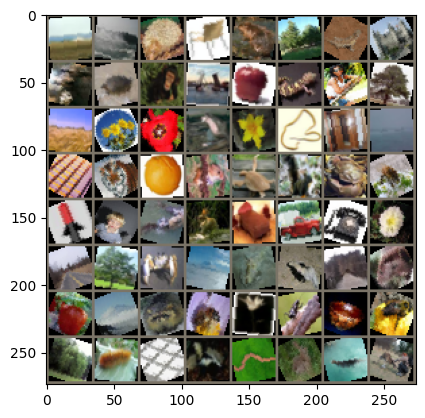

In [45]:
# Check DataLoader
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

imshow(out)

In [46]:

class Net(nn.Module):#마음만은 열넷 v4.0.5
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)#32*32*3 -> 32*32*32
        self.pool = nn.MaxPool2d(2, 2)#32*32*32 -> 16*16*32
        self.batchnorm1 = nn.BatchNorm2d(32)#
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)#16*16*32 -> 16*16*64
        self.pool2 = nn.MaxPool2d(2, 2)#16*16*64 -> 8*8*64
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 100, 3,padding=1)#8*8*64 -> 6*6*100
        self.pool3 = nn.MaxPool2d(2, 2)#6*6*100 -> 3*3*100
        self.batchnorm3 = nn.BatchNorm2d(100)
        self.gap = nn.AdaptiveAvgPool2d((1,1))#3*3*100 -> 1*1*100
        self.dropout = nn.Dropout(0.5)
        #self.fc1 = nn.Linear(100, 100)
        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x)))#32*32*3 -> 32*32*32 -> 16*16*32
        x = self.batchnorm1(x)
        x = self.pool2(F.gelu(self.conv2(x)))#16*16*32 -> 16*16*64 -> 8*8*64
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.pool3(F.gelu(self.conv3(x)))#8*8*64 -> 6*6*100 -> 3*3*100
        #x = self.batchnorm3(x)
        x = self.gap(x)#3*3*100 -> 1*1*100
        x = x.view(-1, 100)#1*1*100 -> 100
        #x = self.fc1(x)#100 -> 100

        return x
        


In [ ]:

class Net_1(nn.Module):#마음만은 열넷 v4.0.7
    def __init__(self):
        super(Net_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)#32*32*3 -> 32*32*32
        self.pool = nn.MaxPool2d(2, 2)#32*32*32 -> 16*16*32
        self.batchnorm1 = nn.BatchNorm2d(32)#
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)#16*16*32 -> 16*16*64
        self.pool2 = nn.MaxPool2d(2, 2)#16*16*64 -> 8*8*64
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)#8*8*64 -> 6*6*100
        self.pool3 = nn.MaxPool2d(2, 2)#6*6*100 -> 3*3*100
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.gap = nn.AdaptiveAvgPool2d((1,1))#3*3*100 -> 1*1*100
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 100)
        self.gelu = nn.GELU()
        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x)))#32*32*3 -> 32*32*32 -> 16*16*32
        x = self.batchnorm1(x)
        x = self.gelu(x)
        x = self.conv2(x)#16*16*32 -> 16*16*64 -> 8*8*64
        x = self.pool2(x)
        x = self.batchnorm2(x)
        x = self.gelu(x)
        x = self.conv3(x)
        x = self.gelu(x)
        x = self.pool3(x)
        x = self.batchnorm3(x)
        x = self.gap(x)#3*3*100 -> 1*1*100
        x = x.view(x.size(0), -1)#1*1*100 -> 100
        x = self.dropout(x)
        x = self.fc1(x)#100 -> 100

        return x

In [47]:
for batch, (X,y)in enumerate(train_loader):
    print(batch)
    print(X.shape)
    print(y.shape)
    break

0
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [48]:

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct



In [49]:
device = "cpu"
print("Using {} device".format(device))

model = Net().to(device)

#optimizer = torch.optim.A
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using cpu device


In [50]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
       BatchNorm2d-3           [-1, 32, 16, 16]              64
            Conv2d-4           [-1, 64, 16, 16]          18,496
         MaxPool2d-5             [-1, 64, 8, 8]               0
       BatchNorm2d-6             [-1, 64, 8, 8]             128
           Dropout-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 100, 8, 8]          57,700
         MaxPool2d-9            [-1, 100, 4, 4]               0
AdaptiveAvgPool2d-10            [-1, 100, 1, 1]               0
Total params: 77,284
Trainable params: 77,284
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.66
Params size (MB): 0.29
Estimated Tot

In [51]:

base_correct = 0
for t in range(args['epochs']):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    print("test loop")
    correct = test_loop(valid_loader, model, loss_fn)
    if correct > base_correct:
        print('save model')
        torch.save(model.state_dict(), 'model2.pt')
        base_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 4.740570  [    0/45000]
loss: 4.016734  [ 8192/45000]
loss: 3.926927  [16384/45000]
loss: 3.654242  [24576/45000]
loss: 3.491414  [32768/45000]
loss: 3.340214  [40960/45000]
test loop
Test Error: 
 Accuracy: 17.0%, Avg loss: 3.534630 

save model
Epoch 2
-------------------------------
loss: 3.714983  [    0/45000]
loss: 3.490167  [ 8192/45000]
loss: 3.350933  [16384/45000]
loss: 3.444789  [24576/45000]
loss: 3.225573  [32768/45000]
loss: 3.122806  [40960/45000]
test loop
Test Error: 
 Accuracy: 20.7%, Avg loss: 3.312466 

save model
Epoch 3
-------------------------------
loss: 3.336843  [    0/45000]
loss: 3.138951  [ 8192/45000]
loss: 3.112603  [16384/45000]
loss: 3.176029  [24576/45000]
loss: 3.528406  [32768/45000]
loss: 3.184185  [40960/45000]
test loop
Test Error: 
 Accuracy: 24.9%, Avg loss: 3.131502 

save model
Epoch 4
-------------------------------
loss: 3.321089  [    0/45000]
loss: 3.033549  [ 8192/45000]
loss: 3.193115  [1638

In [52]:
import pandas as pd
model.load_state_dict(torch.load('model2.pt'))
id_list = []
pred_list = []
_id = 0
model.eval()
with torch.no_grad():
    for x in test_loader:
        preds = model(x)
        preds = preds.argmax(1)
        for pred in preds:
            id_list.append(_id)
            pred_list.append(pred.item())
            _id += 1

res = pd.DataFrame({
    'id_idx': id_list,
    'label': pred_list
}) 

res.sort_values(by='id_idx', inplace=True)

res.to_csv('./result.csv', index=False) 